In [1]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
import pickle
key = random.PRNGKey(0)

from utils import uniaxial_relax2, sigma_split_vmap, sigma_neoHook_vmap, init_params_nobias, init_params_positivebias, dPhi_gov_vmap, dPhi_vmap, plot45

In [2]:
# Functions for training
@partial(jit, static_argnums=(0,1,2,))
def step(loss_fn, norm, useNODE, i, opt_state, inp_batch, out_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, norm, useNODE, inp_batch, out_batch)
    return opt_update(i, g, opt_state)

def train(inp, out, norm, useNODE, opt_state, key, loss_fn, nIter = 1000, batch_size=10, print_freq=100):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, inp.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(loss_fn, norm, useNODE, it, opt_state, inp[i], out[i])
        if it % print_freq == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss_fn(params, norm, useNODE, inp, out)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 


# Define loss functions
def uniaxial_relax_loss(params, norm, useNODE, inp, out):
    time = inp[0]
    lm1_0 = inp[1][0]
    sigma_pr,_,_,_,_,_,_ = uniaxial_relax2(params, norm, useNODE, time, lm1_0)
    # loss = np.mean(np.exp(-(time/100.0))*(sigma_pr[:,0,0]-out)**2)# + (sigma_pr[:,1,1]-out[1])**2)
    loss = np.mean((sigma_pr[:,0,0]-out)**2)# + (sigma_pr[:,1,1]-out[1])**2)
    return loss
uniaxial_relax_loss_vmap = vmap(uniaxial_relax_loss, in_axes=(None, None, None, 0, 0), out_axes=0)
uniaxial_relax_batch_loss = lambda params, norm, useNODE, inp, out: np.mean(uniaxial_relax_loss_vmap(params, norm, useNODE, inp, out))

def Psi_loss(params, norm, useNODE, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.average((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.average((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss3 = np.average((sigma_pr[:,2,2]-sigma_gt[:,2,2])**2)
    loss = (loss1+loss2+loss3)/3
    return  loss

def Phi_loss(params, norm, useNODE, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params, norm)
    loss = np.average((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.average((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.average((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss

# 1. Train Govindjee's model

In [3]:
with open('training_data/Brain/Average/C1/Comp relaxation/CR.npy','rb') as f:
    time, sgm_x = np.load(f).T
lm0 = 0.9
time = np.expand_dims(time,0)
sgm_x = np.expand_dims(sgm_x,0)

lm1 = np.ones_like(time)*lm0
inp = np.array([time, lm1]).transpose([1,0,2])
out = -sgm_x

In [4]:
# Neo Hookean:
mu = 77.77*0.1
K = 1.0
gov_Psi_eq_params = [K, mu]
gov_Psi_neq_params = [K, mu]

eta_D = 1360.0
eta_V = 175000.0
gov_Phi_params = [np.log(eta_D*0.1), np.log(eta_V*0.1)]

gov_params = [gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params]
gov_norm = (None, None, None)

In [5]:
lr = 1.0e-3
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(gov_params)
gov_params, train_loss, val_loss = train(inp, out, gov_norm, False, opt_state, key, uniaxial_relax_batch_loss, nIter = 30000, batch_size=1, print_freq=1000)
    
with open('saved/brain_CR_gov_params.npy', 'wb') as f:
    pickle.dump(gov_params, f)

it 0, train loss = 5.194163e+00
it 1000, train loss = 1.514071e+00
it 2000, train loss = 6.481769e-01
it 3000, train loss = 2.764111e-01
it 4000, train loss = 1.077820e-01
it 5000, train loss = 4.412335e-02
it 6000, train loss = 2.018603e-02
it 7000, train loss = 1.265131e-02
it 8000, train loss = 1.097681e-02
it 9000, train loss = 1.072816e-02
it 10000, train loss = 1.070733e-02
it 11000, train loss = 1.070245e-02
it 12000, train loss = 1.069563e-02
it 13000, train loss = 1.068511e-02
it 14000, train loss = 1.066740e-02
it 15000, train loss = 1.063725e-02
it 16000, train loss = 1.058552e-02
it 17000, train loss = 1.049735e-02
it 18000, train loss = 1.035500e-02
it 19000, train loss = 1.014937e-02
it 20000, train loss = 9.876959e-03
it 21000, train loss = 9.471425e-03
it 22000, train loss = 4.786598e-03
it 23000, train loss = 2.356016e-03
it 24000, train loss = 1.549049e-03
it 25000, train loss = 1.546507e-03
it 26000, train loss = 1.546505e-03
it 27000, train loss = 1.546494e-03
it 28

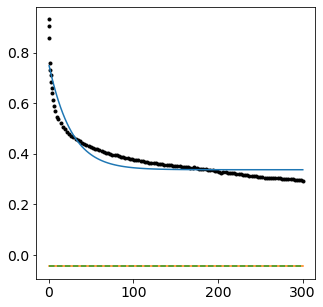

In [6]:
fig, ax = plt.subplots(figsize=[5,5])
sigm_pr, lm1,lm2,lm3,lm1e,lm2e,lm3e = uniaxial_relax2(gov_params, gov_norm, False, time[0], lm0)

ax.plot(time[0],sgm_x[0],'k.')
ax.plot(time[0],-sigm_pr[:,0,0])
ax.plot(time[0],-sigm_pr[:,1,1])
ax.plot(time[0],-sigm_pr[:,2,2], '--')

# 2. Train $\Psi_{EQ}$ and $\Psi_{NEQ}$

In [7]:
with open('saved/brain_CR_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params

In [8]:
# Generate training data
# Inputs
lm = np.linspace(0.7,1.4,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb_1 = np.transpose(np.array([lm1, lm2, lm3]))
lmb_2 = np.transpose(np.array([lm1, lm2, lm3*0.95]))
lmb = np.vstack([lmb_1, lmb_2])

# Outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],gov_Psi_eq_params)

## 2.1 $\Psi_{EQ}$

In [9]:
# Initialize parameters
layers = [1, 5, 5, 1]
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)
Psi_eq_norm = None

# Train
opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_eq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)
with open('saved/brain_CR_Psi_eq_params.npy', 'wb') as f:
    pickle.dump(Psi_eq_params, f)

it 0, train loss = 5.957852e+04
it 10000, train loss = 5.934390e+04
it 20000, train loss = 5.934361e+04
it 30000, train loss = 5.934359e+04
it 40000, train loss = 5.934357e+04
it 50000, train loss = 5.934356e+04
it 60000, train loss = 5.934355e+04
it 70000, train loss = 5.934354e+04
it 80000, train loss = 5.934353e+04
it 90000, train loss = 5.934353e+04
it 100000, train loss = 5.934352e+04
it 110000, train loss = 5.934352e+04
it 120000, train loss = 5.934352e+04
it 130000, train loss = 5.934352e+04
it 140000, train loss = 5.934352e+04
it 150000, train loss = 5.934352e+04
it 160000, train loss = 5.934352e+04
it 170000, train loss = 5.934351e+04
it 180000, train loss = 5.934351e+04
it 190000, train loss = 5.934351e+04
it 200000, train loss = 5.934351e+04


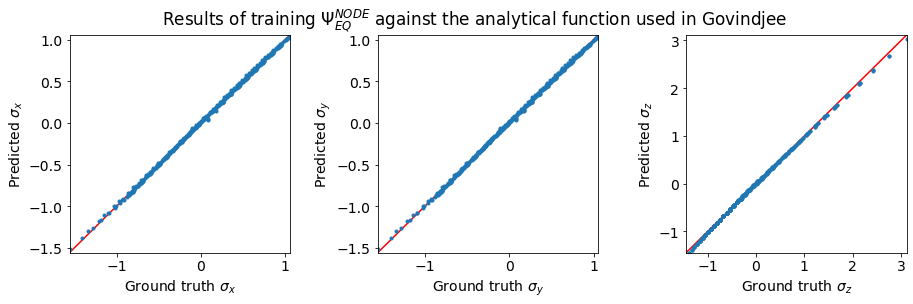

In [10]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_eq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, gov_Psi_eq_params) #since I am using the same MM for both EQ and NEQ
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

## 2.2 $\Psi_{NEQ}$

In [11]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)
Psi_neq_norm = None

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],gov_Psi_neq_params)

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(lmb, sigma_gt, Psi_neq_norm, False, opt_state, key, Psi_loss, nIter = 200000, batch_size=10, print_freq=10000)

with open('saved/brain_CR_Psi_neq_params.npy', 'wb') as f:
    pickle.dump(Psi_neq_params, f)

it 0, train loss = 7.662636e+04
it 10000, train loss = 7.639350e+04
it 20000, train loss = 7.639319e+04
it 30000, train loss = 7.639316e+04
it 40000, train loss = 7.639314e+04
it 50000, train loss = 7.639313e+04
it 60000, train loss = 7.639311e+04
it 70000, train loss = 7.639310e+04
it 80000, train loss = 7.639310e+04
it 90000, train loss = 7.639309e+04
it 100000, train loss = 7.639309e+04
it 110000, train loss = 7.639309e+04
it 120000, train loss = 7.639309e+04
it 130000, train loss = 7.639308e+04
it 140000, train loss = 7.639308e+04
it 150000, train loss = 7.639308e+04
it 160000, train loss = 7.639308e+04
it 170000, train loss = 7.639308e+04
it 180000, train loss = 7.639308e+04
it 190000, train loss = 7.639308e+04
it 200000, train loss = 7.639308e+04


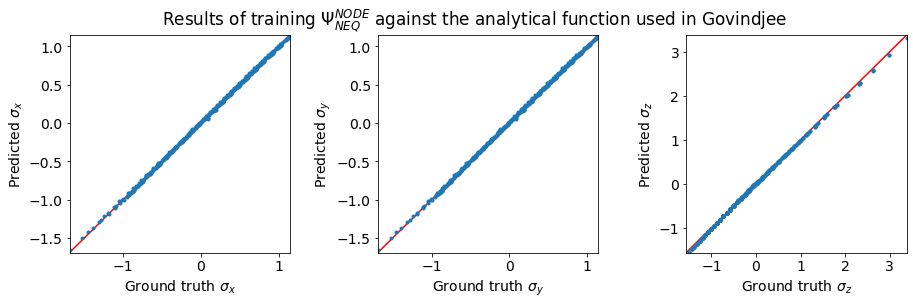

In [12]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_neq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, gov_Psi_neq_params)
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

# 3. Train $\Phi^{NODE}$ with $\Phi^{Govindjee}$

In [13]:
with open('saved/brain_CR_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params
eta_D, eta_V = gov_Phi_params

In [14]:
# Generate training data
# Input data and normalization factors
taui = onp.mgrid[-200:200:10j, -200:200:10j, -200:200:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

# inp_std1 = onp.std(tau1)
# inp_std2 = onp.std(tau1 + tau2)
inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = (inp_std3, inp_std4, inp_std5)

# out_std1 = 1.0
# out_std2 = 1.0
out_std3 = 1.0
out_std4 = 1/9/175000
out_std5 = 1/3/1360
out_stds = (out_std3, out_std4, out_std5)
Phi_norm = (inp_stds, out_stds)

# Output data
dphidtaui = onp.array(dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)).transpose()

# Initialize NN weights
layers = [1,2,3,1]
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
Phi_params = [NODE3_params, NODE4_params, NODE5_params]

In [15]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss, val_loss = train(taui, dphidtaui, Phi_norm, False, opt_state, key, Phi_loss, nIter = 100000, batch_size=100, print_freq=10000)

with open('saved/brain_CR_Phi_params.npy', 'wb') as f:
    pickle.dump(Phi_params, f)
with open('saved/brain_CR_Phi_norm_w.npy', 'wb') as f:
    pickle.dump(Phi_norm, f)

it 0, train loss = 3.122684e+01
it 10000, train loss = 1.699272e+01
it 20000, train loss = 8.818246e+00
it 30000, train loss = 5.526581e-01
it 40000, train loss = 1.750728e-02
it 50000, train loss = 1.729531e-02
it 60000, train loss = 1.721679e-02
it 70000, train loss = 1.721817e-02
it 80000, train loss = 1.722105e-02
it 90000, train loss = 1.722378e-02
it 100000, train loss = 1.721634e-02


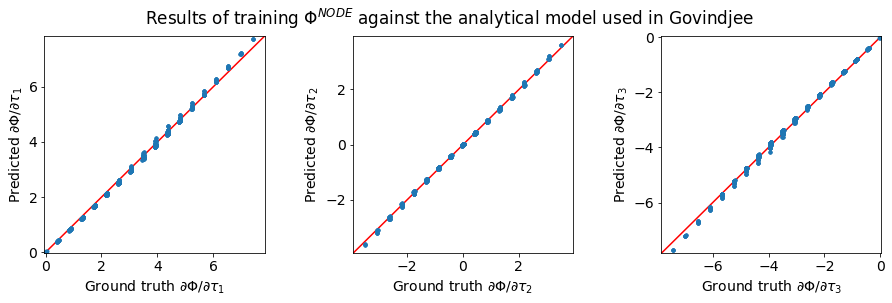

In [16]:
prs = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params, Phi_norm)
gts = dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)

labels = ['$\partial \Phi / \partial \\tau_1$', '$\partial \Phi / \partial \\tau_2$', '$\partial \Phi / \partial \\tau_3$']
title = r"Results of training $\Phi^{NODE}$ against the analytical model used in Govindjee"
plot45(gts, prs, labels, title)

# 4. Test

In [17]:
#Load the pre-trained parameters
with open('saved/brain_CR_Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/brain_CR_Psi_neq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('saved/brain_CR_Phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/brain_CR_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
params = (Psi_eq_params, Psi_neq_params, Phi_params)
norm = (None, None, Phi_norm)

with open('saved/brain_CR_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)

with open('training_data/Brain/Average/C1/Comp relaxation/CR.npy','rb') as f:
    time, sgm_x = np.load(f).T
lm0 = 0.9
time = np.expand_dims(time,0)
sgm_x = np.expand_dims(sgm_x,0)

lm1 = np.ones_like(time)*lm0
inp = np.array([time, lm1]).transpose([1,0,2])
out = -sgm_x

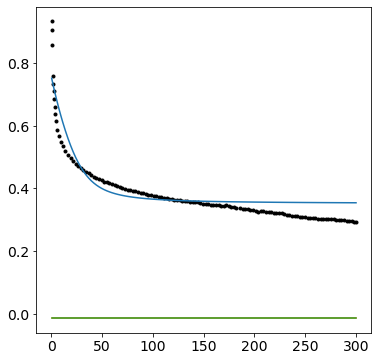

In [18]:
fig, ax = plt.subplots(figsize=(6,6))

t = time[0]
sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_relax2(params, norm, True, t, lm0)

ax.plot(t, sgm_x[0], 'k.')
ax.plot(t,-sig_NN[:,0,0])
ax.plot(t,-sig_NN[:,1,1])
ax.plot(t,-sig_NN[:,2,2])

# 5. Retrain

2022-12-09 21:33:30.932465: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_step.191
********************************


it 0, train loss = 2.399538e-03
it 100, train loss = 1.494728e-03
it 200, train loss = 1.374866e-03
it 300, train loss = 1.254191e-03
it 400, train loss = 1.156471e-03
it 500, train loss = 1.093502e-03
it 600, train loss = 1.044500e-03
it 700, train loss = 1.008024e-03
it 800, train loss = 9.834870e-04
it 900, train loss = 9.466654e-04
it 1000, train loss = 9.205066e-04
it 1100, train loss = 8.960914e-04
it 1200, train loss = 8.766745e-04
it 1300, train loss = 8.619914e-04
it 1400, train loss = 8.514452e-04
it 1500, train loss = 8.440230e-04
it 1600, train loss = 8.392378e-04
it 1700, train loss = 8.356386e-04
it 1800, train loss = 8.323345e-04
it 1900, train loss = 8.291150e-04
it 2000, train loss = 8.262832e-04


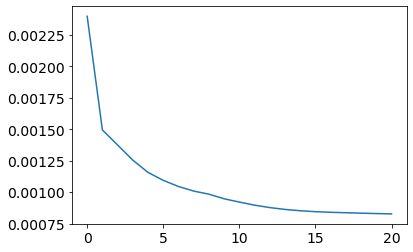

In [19]:
opt_init, opt_update, get_params = optimizers.adam(1.e-3)
opt_state = opt_init(params)

params, train_loss, val_loss = train(inp, out, norm, True, opt_state, key, uniaxial_relax_batch_loss, nIter = 2000, batch_size=1, print_freq=100)

with open('saved/brain_CR_params_retrained.npy', 'wb') as f:
    pickle.dump(params, f)

plt.plot(train_loss)

# 6. Final test

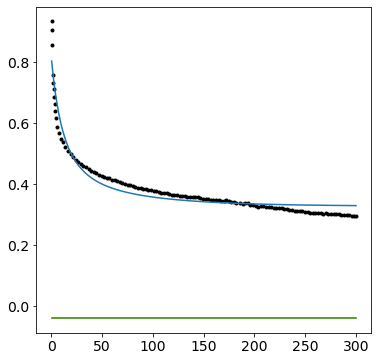

In [20]:
with open('saved/brain_CR_params_retrained.npy', 'rb') as f:
    params = pickle.load(f)
with open('training_data/Brain/Average/C1/Comp relaxation/CR.npy','rb') as f:
    time, sgm_x = np.load(f).T
with open('saved/brain_CR_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
norm = (None, None, Phi_norm)
lm0 = 0.9

fig, ax = plt.subplots(figsize=(6,6))

sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = uniaxial_relax2(params, norm, True, time, lm0)

ax.plot(time, sgm_x, 'k.')
ax.plot(time,-sig_NN[:,0,0])
ax.plot(time,-sig_NN[:,1,1])
ax.plot(time,-sig_NN[:,2,2])